In [295]:
import netCDF4 as nc
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import collections
import xarray as xr
import statistics
import shapefile
from shapely.geometry import shape, Point
import imageio
#from IPython.display import Image
import plotly.express as px
from datetime import datetime
import random
from PIL import Image

plt.style.use('ggplot')

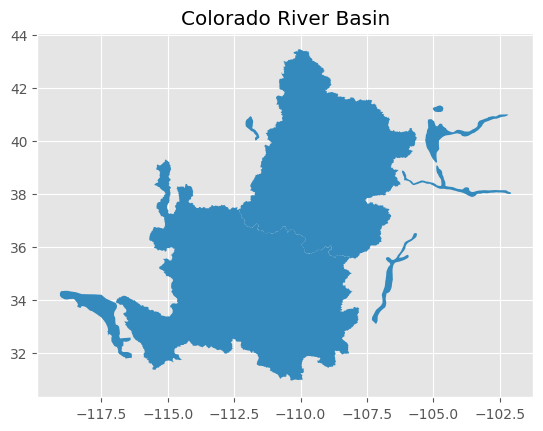

In [2]:
s = gpd.read_file("/home/maiampow/code/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shx")

s.plot()
plt.title("Colorado River Basin")
plt.show()

# Loading & formatting GRACE data

In [3]:
gr = xr.load_dataset("/home/maiampow/remoteData/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc")

gr_df = gr.to_dataframe()
gr_df.reset_index(inplace=True)
gr_df = gr_df.dropna()
gr_df = gr_df.drop_duplicates()

In [4]:
gr_df.reset_index(drop=True,inplace=True)

In [5]:
#converting longitude
gr_df["lon"] = [l-180 for l in gr_df["lon"]]

In [6]:
#multiplying scale factor
gr_df["lwe"] = [x*y for x,y in zip(gr_df["lwe_thickness"],gr_df["scale_factor"])]

In [7]:
#keeping only relevant columns
gr_df_crb = gr_df[["time","lon","lat","lwe"]]

### Subsetting to only points within the Colorado River Basin

In [8]:
#subsetting to rectangle containing the Colorado River Basin
gr_df_crb = gr_df_crb[(gr_df_crb.lon> -120) & (gr_df_crb.lon < -100)]
gr_df_crb = gr_df_crb[(gr_df_crb.lat> 30) & (gr_df_crb.lat < 44)]

In [11]:
gdf = gr_df_crb[["lon","lat"]]

gdf_points = gpd.GeoDataFrame(gdf, 
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(gdf['lon'],
                                                          gdf['lat']))

In [14]:
grace_crb_df = pd.DataFrame()
itera = 0

for sh in s["geometry"]:
    temp_df = gr_df_crb[gdf_points.intersects(sh)]
    #temp_df = gr_df_crb[[sh.contains(Point(a,b)) for a,b in zip(gr_df_crb["lon"],gr_df_crb["lat"])]]
    grace_crb_df = pd.concat([grace_crb_df,temp_df])
    print(itera)
    itera+=1

0
1
2
3
4
5
6
7


In [16]:
grace_crb_df.to_csv("new_grace_crb_df.csv")

### "Upsampling" GRACE Data $(0.5° \times 0.5° \rightarrow 0.25° \times 0.25°)$

In [18]:
up_gr_df = pd.DataFrame()

for t in collections.Counter(grace_crb_df["time"]).keys():
    
    sub_df_gr = grace_crb_df[grace_crb_df["time"] == t]
    #print(t)
    
    for x,y in zip(sub_df_gr["lon"], sub_df_gr["lat"]):
                
        xx = [round(x-0.125,3), round(x+0.125,3)] 
        yy = [round(y-0.125,3), round(y+0.125,3)]
        
        val_df = sub_df_gr[(sub_df_gr["lon"]==x)&(sub_df_gr["lat"]==y)]

        temp_df = pd.DataFrame()
                    
        temp_df["time"] = [t]*4
        temp_df["lon"] = [xx[0],xx[0],xx[1],xx[1]]
        temp_df["lat"] = [yy[0],yy[1],yy[0],yy[1]]
        temp_df["lwe_thickness"] = [val_df["lwe"].mean()]*4

        up_gr_df = pd.concat([up_gr_df,temp_df])

## Loading and formatting GLDAS data

In [241]:
gl_df = pd.read_csv("/home/maiampow/remoteData/CSV/gldas_crb_df.csv")
gl_df = gl_df[["time","lat","lon","SWE_inst","SoilMoi0_10cm_inst"]]
gl_df = gl_df.drop_duplicates()
gl_df["time"] = [t[0:7] for t in gl_df["time"]]
gl_df["time"] = [datetime.strptime(t, '%Y-%m') for t in gl_df["time"]]

In [242]:
gl_df.reset_index(drop=True,inplace=True)

# Computing Groundwater

### Establishing baseline means (January 2004 - December 2009)

In [190]:
baseline_dates = ['2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', 
                  '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', 
                  '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', 
                  '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', 
                  '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', 
                  '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12']

In [243]:
baseline_df = gl_df[gl_df.time.isin(baseline_dates)]

In [244]:
baseline_vals = []

for t in collections.Counter(baseline_df["time"]):
    
    sub_df = baseline_df[baseline_df["time"] == t]
    
    baseline_vals.append((statistics.mean(sub_df["SWE_inst"]),statistics.mean(sub_df["SoilMoi0_10cm_inst"])))
    
baseline_vals = np.array(baseline_vals)

swe_mean = statistics.mean(baseline_vals[:,0])
sm_mean = statistics.mean(baseline_vals[:,1])

### Converting columns to deviations from mean

In [245]:
gl_df["delta_SWE_inst"] = [swe-swe_mean for swe in gl_df["SWE_inst"]]
gl_df["delta_SoilMoi0_10cm_inst"] = [sm-sm_mean for sm in gl_df["SoilMoi0_10cm_inst"]]

In order to compute the deviation from the mean ($d_i$), for each measurement $p_i$, you compute

$$d_i = p_i - \mu$$

where $\mu$ is the average value over the time series*. We then plot these distances to obtain the devations from the mean over time.

*Note that GRACE data is computed based upon a basetime time period of January 2004 to December 2009. 

<p align="center">
    <img src="plots.png" width="750" />
</p>

## Computing groundwater anomolies

### Converting to meters

In [246]:
gl_df["delta_sm"] = [m*0.1 for m in gl_df["delta_SWE_inst"]]
gl_df["delta_swe"] = [m*0.1 for m in gl_df["delta_SoilMoi0_10cm_inst"]]

In [257]:
up_gr_df["lwe"] = [0.1*l for l in up_gr_df["lwe_thickness"]]

### Getting data into Year-Month format

In [247]:
up_gr_df["time"] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in up_gr_df["time"]]

In [248]:
gl_df["time"] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in gl_df["time"]]

In [249]:
up_gr_df.reset_index(drop=True,inplace=True)

In [250]:
gl_df.reset_index(drop=True,inplace=True)

## Combining dataframes

In [258]:
combo_df = up_gr_df.merge(gl_df, on=["time", "lat", "lon"], how="inner")

In [259]:
combo_df

time      lon     lat  lwe_thickness       lwe    SWE_inst  \
0      2002-04-01 -104.875  41.125       1.545953  0.154595    0.027792   
1      2002-04-01 -104.875  41.125       1.545953  0.154595    0.027792   
2      2002-04-01 -107.125  33.375       5.024540  0.502454    0.000000   
3      2002-04-01 -107.125  33.375       5.024540  0.502454    0.000000   
4      2002-04-01 -106.625  34.625       1.102803  0.110280    0.000000   
...           ...      ...     ...            ...       ...         ...   
464275 2023-03-01 -106.125  40.125     -15.051348 -1.505135  100.668950   
464276 2023-03-01 -105.875  40.125     -13.153895 -1.315389   98.232056   
464277 2023-03-01 -105.875  40.125     -13.153895 -1.315389   98.232056   
464278 2023-03-01 -105.875  40.375     -13.153895 -1.315389  120.753190   
464279 2023-03-01 -105.875  40.375     -13.153895 -1.315389  120.753190   

        SoilMoi0_10cm_inst  delta_SWE_inst  delta_SoilMoi0_10cm_inst  \
0                16.936634       -3.153442                 -1.008622   
1                16.936634       -3.153442                 -1.008622   
2                 9.807609       -3.181234                 -8.137647   
3                 9.807609       -3.181234                 -8.137647   
4                 6.137658       -3.181234                -11.807598   
...                    ...             ...                       ...   
464275           43.353634       97.487716                 25.408378   
464276           43.359653       95.050822                 25.414397   
464277           43.359653       95.050822                 25.414397   
464278           33.760050      117.571956                 15.814794   
464279           33.760050      117.571956                 15.814794   

         delta_sm  delta_swe  
0       -0.315344  -0.100862  
1       -0.315344  -0.100862  
2       -0.318123  -0.813765  
3       -0.318123  -0.813765  
4       -0.318123  -1.180760  
...           ...        ...  
464275   9.748772   2.540838  
464276   9.505082   2.541440  
464277   9.505082   2.541440  
464278  11.757196   1.581479  
464279  11.757196   1.581479  

[464280 rows x 11 columns]

In [274]:
combo_df.to_csv("combo_df.csv")

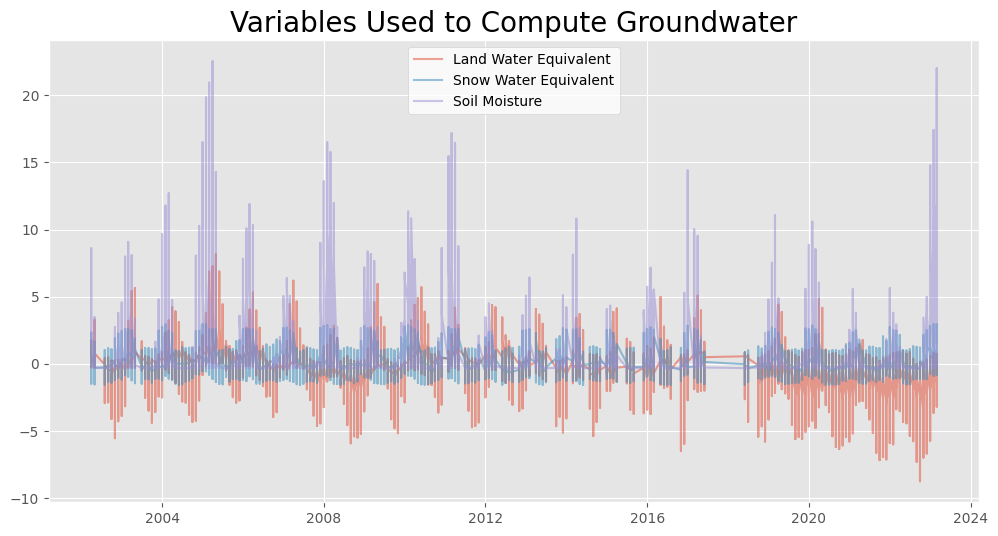

In [275]:
plt.figure(figsize=(12,6))
plt.plot(combo_df["time"],combo_df["lwe"],alpha=0.5)
plt.plot(combo_df["time"],combo_df["delta_swe"],alpha=0.5)
plt.plot(combo_df["time"],combo_df["delta_sm"],alpha=0.5)
plt.title("Variables Used to Compute Groundwater", fontsize=20)
plt.legend(["Land Water Equivalent", "Snow Water Equivalent", "Soil Moisture"],facecolor="w")
plt.show()

## Computing groundwater

In [276]:
gw_est = []

for i in range(0,len(combo_df)):
    il = combo_df.iloc[i]
    gw = il["lwe"] - (il["delta_swe"] + il["delta_sm"])
    gw_est.append(gw)

In [277]:
combo_df["gw_est"] = gw_est

# Visualizations

### Aggregating over the Colorado River Basin

In [278]:
gw_data = []

for t in collections.Counter(combo_df["time"]).keys():
    sub_df = combo_df[combo_df["time"] == t]
    gw_data.append((t,statistics.mean(sub_df["gw_est"])))

In [279]:
gw_arr = np.array(gw_data)

In [280]:
gw_df = pd.DataFrame()
gw_df["time"] = gw_arr[:,0]
gw_df["gw"] = gw_arr[:,1]

## Static visualization with x-axis slider

In [306]:
fig = px.line(gw_df, x="time", y="gw", 
              color_discrete_sequence = ['LightSeaGreen'],
             labels={"time": "Time (in Months)",
                     "gw": "Groundwater Anomoly (m)"})
fig.update_layout(
    title={
        'text': "Groundwater Anomaly Estimates",
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update_xaxes(rangeslider_visible=True)
fig.update_traces(opacity=0.5)

## Animated GIF

In [293]:
filenames = []
i = 0

for tp in collections.Counter(combo_df["time"]).keys():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    s.plot(color="lightgrey", ax=ax, edgecolor='k')

    sub_df = combo_df[combo_df["time"] == tp]

    x = sub_df['lon']
    y = sub_df['lat']
    z = sub_df['gw_est']
    plt.scatter(x, y, c=z,
                cmap='spring_r',marker="s", sizes=[50]*len(x))
    plt.colorbar(label='Groundwater Anomaly')
    plt.clim(-10,10)
    plt.title(tp)
    
    # plot the line chart
    #plt.plot(y[:i])
    #plt.ylim(20,50)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    i+=1
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
# build gif
with imageio.get_writer('groundwater_combo.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_3068681/1118794891.py:35: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [298]:
a = Image.open("groundwater_combo.gif")

a.save('pillow_combo_groundwater.gif',
               save_all=True, loop=0) #making gif loop infinitely

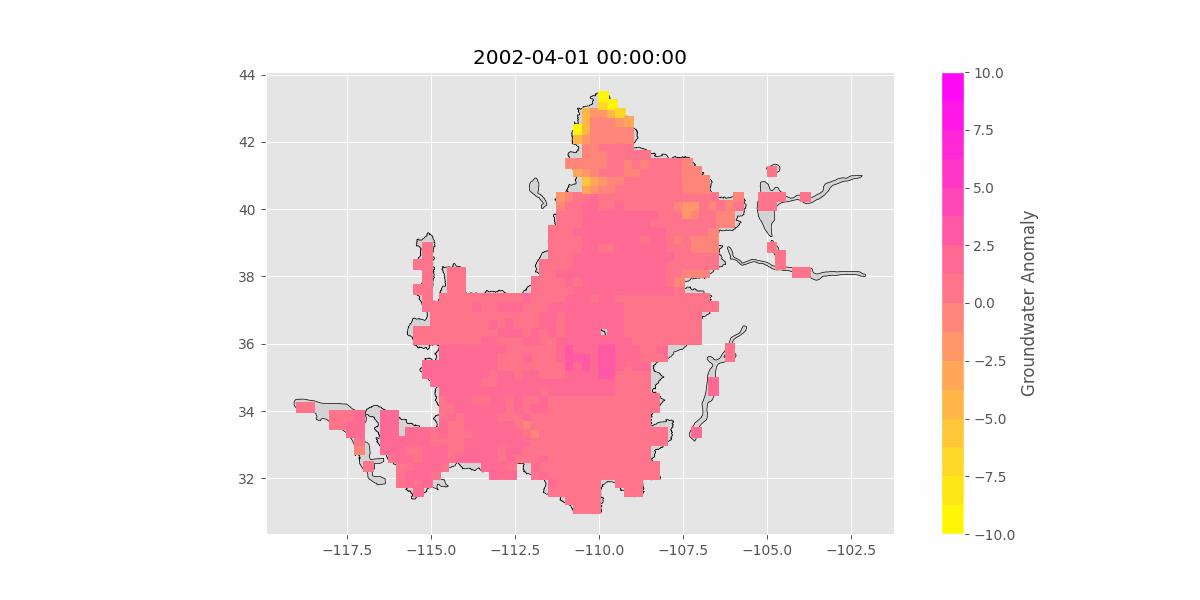

In [305]:
from IPython.display import Image
Image('pillow_combo_groundwater.gif')